In [17]:
import numpy as np
import pandas as pd

from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/processed_data/covid-19-state-level.csv', index_col=0)

In [4]:
# We will use it to smooth the data
def smoother(inputdata, w, imax):
    data = 1.0 * inputdata
    data = data.replace(np.nan, 1)
    data = data.replace(np.inf, 1)
    # print(data)
    smoothed = 1.0 * data
    normalization = 1
    for i in range(-imax, imax + 1):
        if i==0:
            continue
        smoothed += (w ** abs(i)) * data.shift(i, axis=0)
        normalization += w ** abs(i)
    smoothed /= normalization
    return smoothed

In [5]:
# function to compute growth factor
def growth_factor(confirmed):
    confirmed_iminus1 = confirmed.shift(1, axis=0)
    confirmed_iminus2 = confirmed.shift(2, axis=0)
    return (confirmed-confirmed_iminus1)/(confirmed_iminus1-confirmed_iminus2)

In [6]:
#function to compute growth ratio
def growth_ratio(confirmed):
    confirmed_iminus1 = confirmed.shift(1, axis=0)
    return (confirmed/confirmed_iminus1)

In [15]:
# This is a function which plots (for in input state) the confirmed cases, deaths, and the growth factor.
def plot_state_growth_metrics(data, state):
    # Plots Active, Confirmed, and Recovered Cases. Also plots deaths.
    state_data = data[data['state']==state]
    table = state_data[['date', 'cases', 'deaths']]
    
    table2 = pd.pivot_table(table, values=['cases', 'deaths'], index=['date'], aggfunc=np.sum)
    
    # Plot cases
    table3 = table2.drop(['deaths'], axis=1)
   
    # Growth Factor
    w = 0.5
    table2['growth_factor'] = growth_factor(table2['cases'])
    table2['growth_factor'] = smoother(table2['growth_factor'], w, 5)

    # 2nd Derivative
    table2['2nd_derivative'] = np.gradient(np.gradient(table2['cases'])) #2nd derivative
    table2['2nd_derivative'] = smoother(table2['2nd_derivative'], w, 7)

    # Plot confirmed[i]/confirmed[i-1], this is called the growth ratio
    table2['growth_ratio'] = growth_ratio(table2['cases'])
    table2['growth_ratio'] = smoother(table2['growth_ratio'], w, 5)
    
    # Plot the growth rate, we will define this as k in the logistic function presented at the beginning of this notebook.
    table2['growth_rate']=np.gradient(np.log(table2['cases']))
    table2['growth_rate'] = smoother(table2['growth_rate'], 0.5, 3)
    
    # horizontal line at growth rate 1.0 for reference
    x_coordinates = [1, 100]
    y_coordinates = [1, 1]
    
    #plots
    table3.plot() 
    plt.show()
    # Growth Factor
    table2['growth_factor'].plot(title='Growth Factor')
    plt.plot(x_coordinates, y_coordinates) 
    plt.show()
    # 2nd Derivative
    table2['2nd_derivative'].plot(title='2nd_Derivative')
    plt.show()
    # Growth Ratio
    table2['growth_ratio'].plot(title='Growth Ratio')
    plt.plot(x_coordinates, y_coordinates)
    plt.show()
    # Growth Rate
    table2['growth_rate'].plot(title='Growth Rate')
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1057: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1078: RuntimeWarning: invalid value encountered in double_scalars
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0


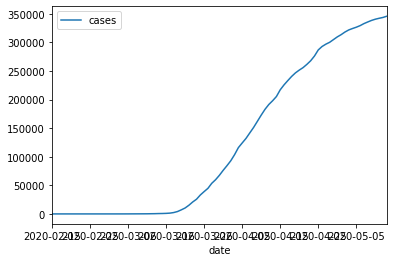

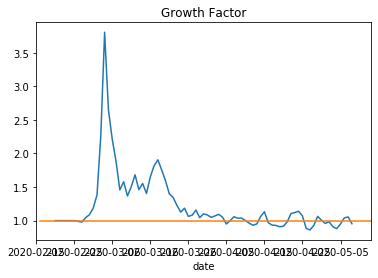

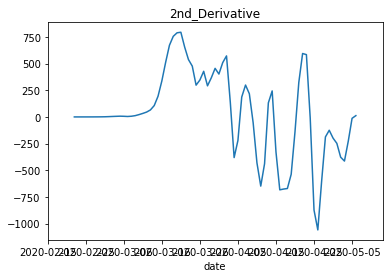

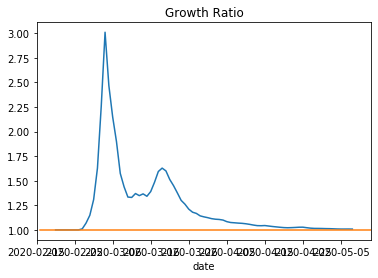

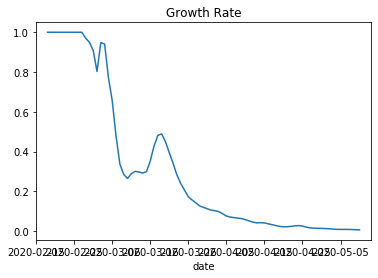

In [16]:
plot_state_growth_metrics(df, 'New York')

### Logistic Curve Fitting

We are going to use scipy.optimize.curve_fit to fit a logistic curve to the number of confirmed cases in US.

In [66]:
df['state'].unique()

array(['Georgia', 'Utah', 'Washington', 'Hawaii', 'Nebraska', 'Vermont',
       'Delaware', 'Alaska', 'Alabama', 'Illinois', 'Idaho', 'Oregon',
       'Nevada', 'Kansas', 'Iowa', 'North Dakota', 'Pennsylvania',
       'Massachusetts', 'Kentucky', 'Ohio', 'New Hampshire',
       'West Virginia', 'District of Columbia', 'Indiana', 'Minnesota',
       'South Carolina', 'Virginia', 'Michigan', 'New York', 'New Jersey',
       'Florida', 'Maine', 'Colorado', 'Arizona', 'Maryland',
       'Mississippi', 'Arkansas', 'California', 'Missouri', 'Louisiana',
       'South Dakota', 'Wisconsin', 'North Carolina', 'Tennessee',
       'Rhode Island', 'Texas', 'New Mexico', 'Montana', 'Connecticut',
       'Oklahoma', 'Wyoming'], dtype=object)

              cases  deaths
date                       
2020-05-09  66824.0  2732.0
2020-05-10  68051.0  2769.0
2020-05-11  69514.0  2820.0
2020-05-12  71150.0  2902.0
2020-05-13  73218.0  3014.0
0.08650401102866409 69.58108818331911 84526.78015817798
date
2020-05-09    66824.0
2020-05-10    68051.0
2020-05-11    69514.0
2020-05-12    71150.0
2020-05-13    73218.0
Name: cases, dtype: float64


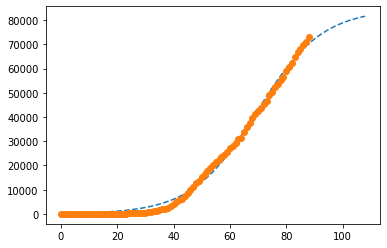

In [70]:
state_data = df[df['state']=='California']

state_data = pd.pivot_table(state_data, values=['cases','deaths'], index=['date'], aggfunc=np.sum)

print(state_data.tail())
# x_data - number of days since first confirmed 
x_data = range(len(state_data.index))
# y_data - confirmed data. This will be the data we use to fit a logistic curve
y_data = state_data['cases']

def log_curve(x, k, x_0, ymax):
    return ymax / (1 + np.exp(-k * (x - x_0)))

# Fit the curve
popt, pcov = curve_fit(log_curve, x_data, y_data, bounds=([0, 0, 0], np.inf), maxfev=5000)
estimated_k, estimated_x_0, ymax= popt

# Plot the fitted curve
k = estimated_k
x_0 = estimated_x_0

y_fitted = log_curve(range(0, len(y_data) + 20), k, x_0, ymax)

print(k, x_0, ymax)

print(y_data.tail())

# Plot everything for illustration
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(range(0, len(y_fitted)), y_fitted, '--', label='fitted')
ax.plot(x_data, y_data, 'o', label='Confirmed Cases')

plt.show()